# Machine Learning: Online News Popularity

In [ ]:
import seaborn as sns
from copy import copy
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RepeatedStratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, recall_score, precision_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
!pip install imblearn
import imblearn
from imblearn.over_sampling import SMOTE
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.impute import SimpleImputer


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Preprocessing

### Exploratory Analysis 

In [ ]:
data=pd.read_csv("https://raw.githubusercontent.com/QBKFD/Article-data/main/OnlineNewsPopularity.csv")

NameError: ignored

In [ ]:
data.shape
AD= data.copy()

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
data.hist(figsize=(20,20))
plt.show()

In [ ]:
ff = data[' shares'].transform([np.log10])
ff.replace([np.inf, -np.inf], np.nan, inplace=True)
ff.dropna()
ff.plot.hist()

In [ ]:
cor=data.corr()
plt.figure(figsize=(15,15))
data_lt = cor.where(np.tril(np.ones(cor.shape)).astype(np.bool))
sns.heatmap(data_lt,cmap='Blues')

### Removing Noise 

In [ ]:
#Identifying all variables with missing values 
n=data.isna().sum()
n[n>0]

No missing values.

In [ ]:
data.columns=data.columns.str.replace(" ","")

In [ ]:
#The number of words in the content is represented by n_tokens_content
#Since its minimum value is 0 there are articles with no words that have to be removed
num_of_nowords=data[data['n_tokens_content']==0].index
print('Number news articles with no words',num_of_nowords.size)

#Remove news articles without content
data = data[data['n_tokens_content'] != 0]

In [ ]:
#Remove non predictive features
data = data.drop('url',axis=1)
data = data.drop('timedelta',axis=1)
data = data.drop(["n_non_stop_unique_tokens","n_non_stop_words","kw_avg_min"],axis=1)

In [ ]:
data.info()

## Target Classification label

In [ ]:
#Understanding target variable distribution
data['shares'].describe()

count     38463.000000
mean       3355.360398
std       11585.968776
min           1.000000
25%         945.000000
50%        1400.000000
75%        2700.000000
max      843300.000000
Name: shares, dtype: float64

In [ ]:
data['shares'].median()

1400.0

Outliers affect the mean value of the data but have little effect on the median of a given set of data, therefore we choose the median for the popularity threshold 

In [ ]:
#target label
target_variable = list()
for share in data['shares']:
    if share > 1400:
        target_variable.append('Popular')
    elif share <= 1400:
        target_variable.append('Unpopular')

# Update target label into the dataframe
data = pd.concat([data.reset_index(drop=True), pd.DataFrame(target_variable, columns=['popularity'])], axis=1)

In [ ]:
count = Counter(data['popularity'])


Examination of the effect of the independent variables on the target dependent variable 

In [ ]:
# Get the features from dataset
features = data.head()
features

,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity
0,12.0,219.0,0.663594,4.0,2.0,1.0,0.0,4.680365,5.0,0.0,...,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593,Unpopular
1,9.0,255.0,0.604743,3.0,1.0,1.0,0.0,4.913725,4.0,0.0,...,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711,Unpopular
2,9.0,211.0,0.575130,3.0,1.0,1.0,0.0,4.393365,6.0,0.0,...,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500,Popular
3,9.0,531.0,0.503788,9.0,0.0,1.0,0.0,4.404896,7.0,0.0,...,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200,Unpopular
4,13.0,1072.0,0.415646,19.0,19.0,20.0,0.0,4.682836,7.0,0.0,...,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505,Unpopular


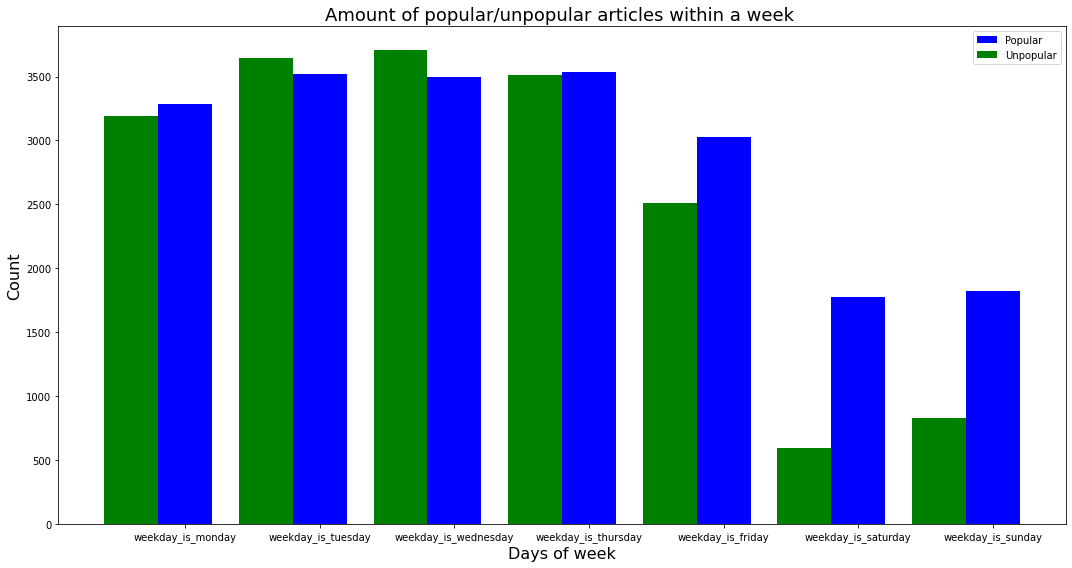

In [ ]:
#Day of the week vs Popularity
col_days = data.columns.values[26:33]
art_npop =data[data['shares']<1400]
art_pop=data[data['shares']>=1400]
npop_day = art_npop[col_days].sum().values
pop_day = art_pop[col_days].sum().values

import matplotlib.pyplot as pl
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

fig = pl.figure(figsize = (15,8))
pl.title("Amount of popular/unpopular articles within a week ", fontsize = 18)
pl.bar(np.arange(len(col_days)), pop_day, width = 0.4, align="center", color = 'b', \
          label = "Popular")
pl.bar(np.arange(len(col_days)) - 0.4, npop_day, width = 0.4, align = "center", color = 'g', \
          label = "Unpopular")
pl.xticks(np.arange(len(col_days)), col_days)
pl.ylabel("Count", fontsize = 16)
pl.xlabel("Days of week", fontsize = 16)
    
pl.legend(loc = 'upper right')
pl.tight_layout()
pl.show()

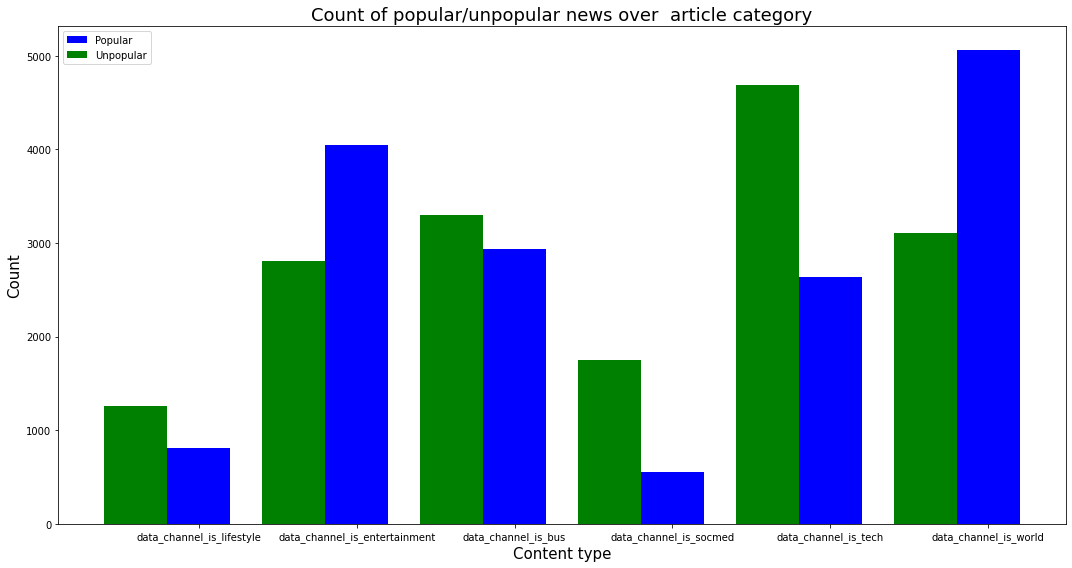

In [ ]:
#Catagory vs Popularity 
cont_type= data.columns.values[9:15]
pop_type = art_npop[cont_type].sum().values
npop_type = art_pop[cont_type].sum().values
fig = pl.figure(figsize = (15,8))
pl.title("Count of popular/unpopular news over  article category", fontsize = 18)
pl.bar(np.arange(len(cont_type)), pop_type, width = 0.4, align="center", color = 'b', \
          label = "Popular")
pl.bar(np.arange(len(cont_type)) - 0.4, npop_type, width = 0.4, align = "center", color = 'g', \
          label = "Unpopular")
pl.xticks(np.arange(len(cont_type)), cont_type)

pl.ylabel("Count", fontsize = 15)
pl.xlabel("Content type", fontsize = 15)
    
pl.legend(loc = 'upper left')
pl.tight_layout()
pl.show()

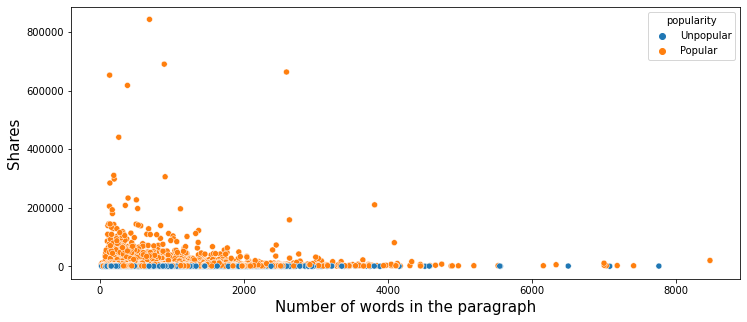

In [ ]:

plt.figure(figsize=(12,5))
ax = sns.scatterplot(y='shares', x='n_tokens_content', hue='popularity', data=data)
pl.ylabel("Shares", fontsize = 15)
pl.xlabel("Number of words in the paragraph", fontsize = 15)
plt.show()

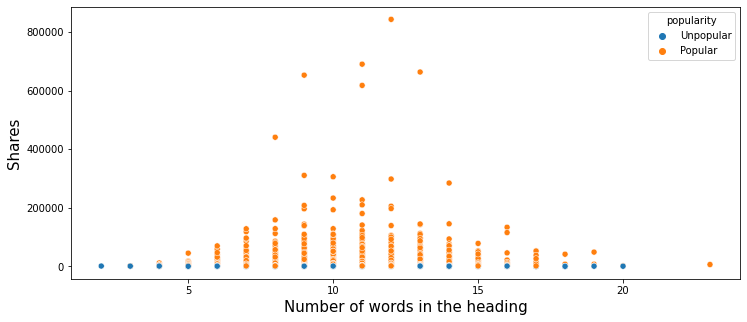

In [ ]:
#Number of words in the heading vs Popularity
plt.figure(figsize=(12,5))
ax = sns.scatterplot(y= 'shares', x='n_tokens_title', hue='popularity', data=data);
pl.ylabel("Shares", fontsize = 15)
pl.xlabel("Number of words in the heading", fontsize = 15)
plt.show()

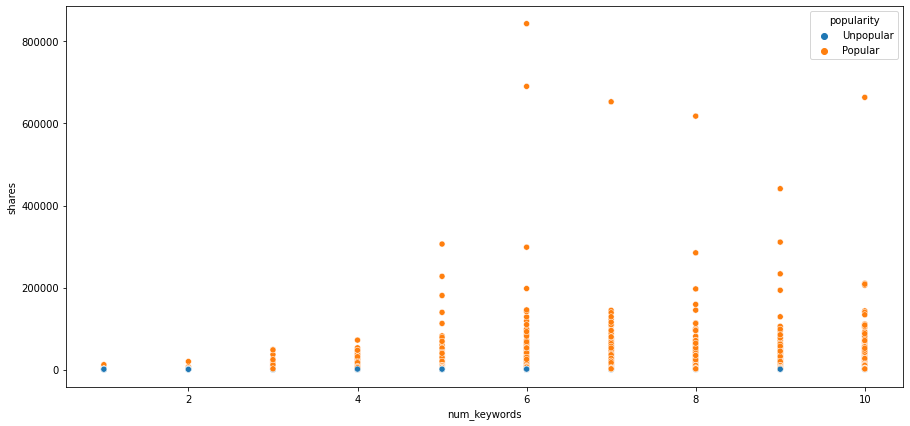

In [ ]:
#Number of key words vs Popularity
plt.figure(figsize=(15,7))
sns.scatterplot(x='num_keywords',y='shares', hue='popularity', data=data)
plt.show()

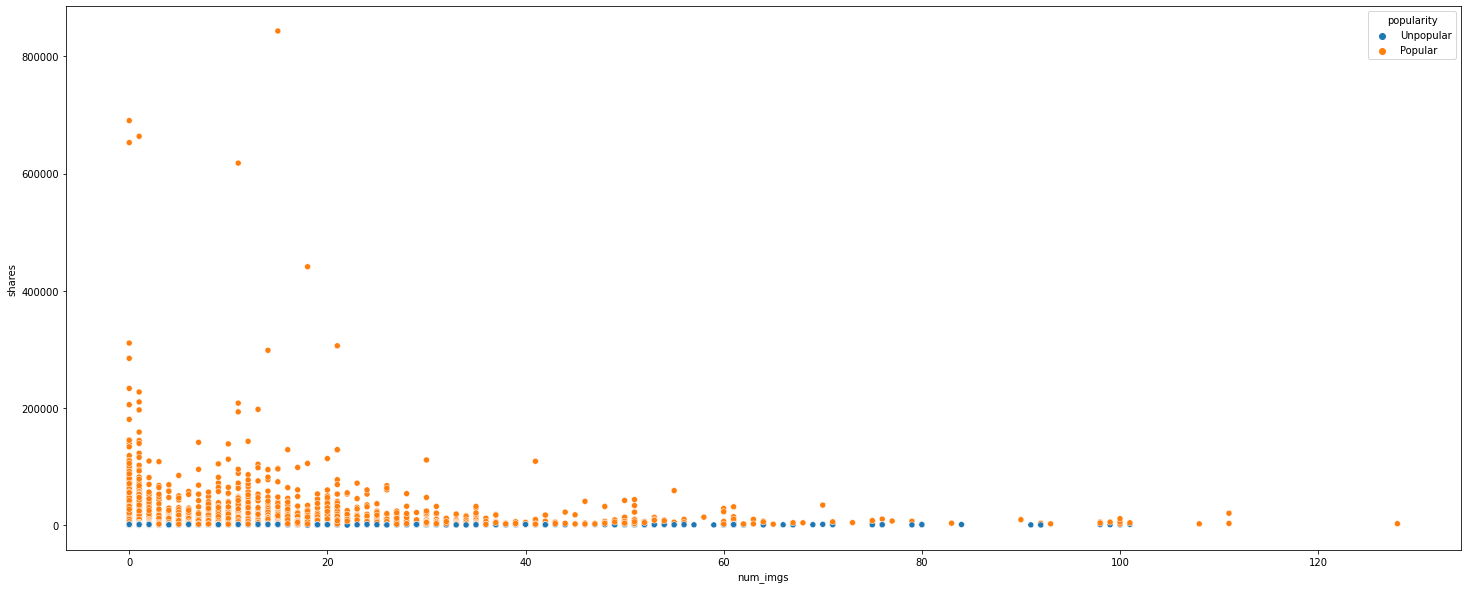

In [ ]:
#Number of images vs Popularity 
plt.figure(figsize=(25,10))
sns.scatterplot(x='num_imgs',y='shares', hue='popularity', data=data)
plt.show()

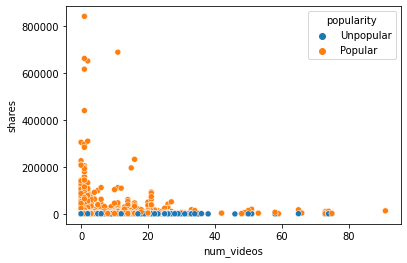

In [ ]:
#Number of videos vs Popularity 
sns.scatterplot(x='num_videos', y='shares', hue='popularity', data=data)
plt.show()

Conclusions

n_tokens_content -> At most 1700 words. Amount over 2000 is having way less shares. 

- n_tokens_title -> Between 7-15 words in the heading.

- n_unique_tokens -> Boundaries about 0.4-0.8. This feature describes rate of unique words in the content.

- num_imgs -> In the interval from 0 - 30 at most. This feature stands for number of images in the article.

- num_videos -> Up to 20 videos per article.

- num_keywords -> This feature should be around 6-10. Relates to number of keywords in the metadata.

- num_hrefs -> Should be somewhere from 0 -75. Defines number of links

- average_token_length -> Defines the average length of words in the content. Should be from 4 up to 6 words.

- weekdays -> Tuesdays and Wednesdays are definitely days with the highest number of shares. On the other hand weekends are not worth publishing.

- types -> Most popular categories are world and entertainment.

## Transforming and scaling the data

A normal distribution cannot be found in the provided data.
To change the entire set of data into a distribution that is as close to normal as possible, a log transformation will be used. 

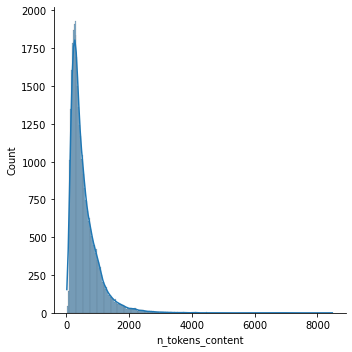

In [ ]:
# before log transformation
original_data = copy(data)
sns.displot(original_data['n_tokens_content'], kde=True);

In [ ]:
#Transforming features to a normal distribution by applying log transformation.
#Note: It can only be done to non-zero features to avoid dividing by zero.

for col in data.iloc[:,:-1].columns:
    temp = data[data[col] == 0]
    if temp.shape[0] == 0:
        data[col] = np.log(data[col])

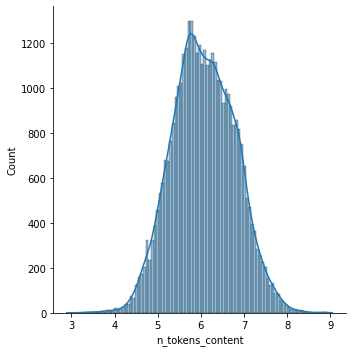

In [ ]:
# distribution after log transformation
sns.displot(data['n_tokens_content'], kde=True)

In [ ]:
# scale features using statistics that are robust to outliers.
# The RobustScaler is used because it is based on percentiles
#  therefore not influenced by a small number of very large marginal outliers. 
# Note that the outliers themselves are still present in the transformed data.
# source: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# feature scaling all data besides the shares and popularity features
scaled_data = scaler.fit_transform(data.iloc[:, :-2])

# update data with the scaled featrues
data.iloc[:, :-2] = scaled_data


In [ ]:
# the data after log transformation and robust scaler
data.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,...,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000,38463.000000
mean,0.055374,0.019763,-0.044655,0.357541,0.131590,1.187687,1.263786,0.014622,-0.024493,0.054000,...,-0.032476,-0.050093,-0.070626,-0.094503,-0.144014,0.311147,0.520642,-0.472706,0.619718,7.469288
std,0.734370,0.703282,0.802998,1.260064,1.289924,2.765122,4.164896,0.764963,0.730870,0.226021,...,1.407646,0.531272,0.877328,0.696149,1.265583,0.647122,1.938480,0.565818,0.902544,0.925483
min,-5.594502,-3.050697,-6.288267,-0.888889,-1.000000,-0.333333,0.000000,-3.339577,-4.799205,0.000000,...,-2.000000,-2.000000,-5.374142,-1.244444,-12.000000,-0.250000,-7.333333,-1.500000,0.000000,0.000000
25%,-0.366239,-0.474026,-0.521254,-0.333333,-0.666667,0.000000,0.000000,-0.496222,-0.380182,0.000000,...,-1.000000,-0.500000,-0.534287,-0.533333,-0.333333,-0.250000,0.000000,-1.000000,0.000000,6.851185
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.244228
75%,0.633761,0.525974,0.478746,0.666667,0.333333,1.000000,1.000000,0.503778,0.619818,0.000000,...,0.000000,0.500000,0.465713,0.466667,0.666667,0.750000,1.000000,0.000000,1.000000,7.901007
max,2.895242,2.896457,29.014405,32.888889,37.666667,42.333333,91.000000,6.939609,0.879669,1.000000,...,18.000000,0.500000,1.866081,1.244444,1.333333,1.750000,7.333333,0.000000,4.000000,13.645078


## Dimensionality reduction

Dimensionality reduction can also be useful for visualizing the clusters that are found by k-means. K-means is typically used for clustering high-dimensional data, which can be difficult to visualize in its original space. Dimensionality reduction can transform the data into a lower-dimensional space, which makes it easier to visualize and interpret the clusters done later on.

The appropriate method depend on the specific dataset so we try both PCA and t-SNE.

### PCA 

In [ ]:
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data.iloc[:,:-2])
data_reduced.shape

(38463, 2)

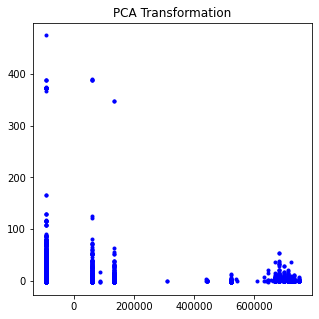

In [ ]:
# plotting the clusters PCA
plt.figure(figsize=(5,5))
plt.plot(data_reduced[:,0], data_reduced[:,1], 'b.')
plt.title('PCA Transformation')

plt.show()

### t-SNE

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=300, random_state=42)
reduced_tsne = tsne.fit_transform(data.iloc[:,:-2])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


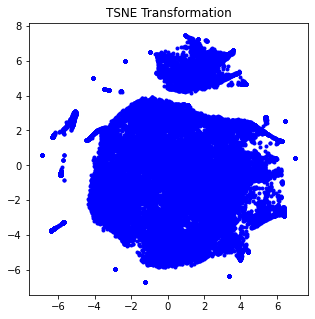

In [ ]:
# plotting the clusters TSNE
plt.figure(figsize=(5,5))
plt.plot(reduced_tsne[:,0], reduced_tsne[:,1], 'b.')
plt.title('TSNE Transformation')
plt.show()


##Needs better explanation##

## Data Clustering

Grouping Similar Articles together

Using the numerical representation of each article we apply the k-means algorithm to group the articles into clusters. The algorithm will iteratively assign each article to the cluster with the nearest centroid (i.e., the center point of the cluster), and then it will update the centroids to be the average of all the articles assigned to that cluster. This process will continue until the centroids stop changing or a predefined number of iterations is reached.

After the algorithm has finished running, we have a set of clusters, each containing a group of similar articles. The we use these clusters to group similar articles together and build a model for all the articles.

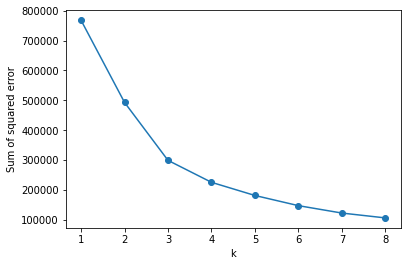

In [ ]:
k=list(range(1,9))
ssd=[]
for i in k:
    kmeans=KMeans(n_clusters=i).fit(reduced_tsne)
    ssd.append(kmeans.inertia_)

plt.plot(k,ssd,'o-')
plt.xlabel('k')
plt.ylabel('Sum of squared error')
plt.show()


In [ ]:
# Predicts the clusters
kmeans=KMeans(init='k-means++',n_clusters=4)
kmeans.fit(reduced_tsne)
kmeans_preds=kmeans.predict(reduced_tsne)

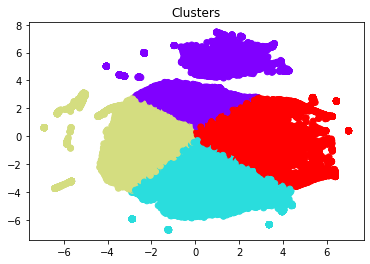

In [ ]:
#Visualizing the clusters
plt.scatter(reduced_tsne[:,0],reduced_tsne[:,1],c=kmeans_preds,cmap='rainbow')
plt.title('Clusters')
plt.show()


In [ ]:
clust_data=pd.concat([data.reset_index(drop=True), pd.DataFrame(kmeans_preds, columns=['cluster'])],axis=1)

In [ ]:
clust_data.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity,cluster
0,0.633761,-0.636134,0.812476,-0.444444,-0.333333,0.000000,0.0,0.017074,-0.829843,0.0,...,-0.667997,-0.248889,-1.333333,0.750000,-1.375,-1.500000,0.750000,6.385194,Unpopular,2
1,-0.366239,-0.489067,0.436317,-0.555556,-0.666667,0.000000,0.0,0.639390,-1.380182,0.0,...,1.006305,0.933333,0.000000,-0.250000,0.000,0.000000,0.000000,6.566672,Unpopular,2
2,-0.366239,-0.672094,0.232948,-0.555556,-0.666667,0.000000,0.0,-0.792290,-0.380182,0.0,...,-1.512690,-0.746667,-0.444444,-0.250000,0.000,0.000000,0.000000,7.313220,Popular,2
3,-0.366239,0.219733,-0.303499,0.111111,-1.000000,0.000000,0.0,-0.758763,0.000000,0.0,...,-0.810607,-0.248889,-0.888889,-0.250000,0.000,0.000000,0.000000,7.090077,Unpopular,2
4,0.911994,0.898597,-1.082499,1.222222,5.333333,6.333333,0.0,0.023824,0.000000,0.0,...,0.271840,0.000000,0.666667,0.659091,1.000,-1.363636,0.545455,6.224558,Unpopular,2


In [ ]:
#creating new datasets from the clusters
clust1_data = clust_data[clust_data['cluster'] == 0]
clust2_data = clust_data[clust_data['cluster'] == 1]
clust3_data = clust_data[clust_data['cluster'] == 2]
clust4_data = clust_data[clust_data['cluster'] == 3]
print ('Cluster1 size: ',clust1_data.shape)
print ('Cluster2 size: ',clust2_data.shape)
print ('Cluster3 size: ',clust3_data.shape)
print ('Cluster4 size: ',clust4_data.shape)

Cluster1 size:  (9079, 58)
Cluster2 size:  (8815, 58)
Cluster3 size:  (11459, 58)
Cluster4 size:  (9110, 58)


In [ ]:
from collections import Counter
# the input variable are the numerical features of each article
# the target ooutput variable is the categorical label popularity

#Cluster 1
X1 = clust1_data.iloc[:, :-3]
y1 = clust1_data.iloc[:, -2]
counter = Counter(y1)
print(counter)

#Cluster 2
X2 = clust2_data.iloc[:, :-3]
y2 = clust2_data.iloc[:, -2]
counter = Counter(y2)
print(counter)

#Cluster 3
X3 = clust3_data.iloc[:, :-3]
y3 = clust3_data.iloc[:, -2]
counter = Counter(y3)
print(counter)

#Cluster 4
X4 = clust4_data.iloc[:, :-3]
y4 = clust4_data.iloc[:, -2]
counter = Counter(y1)
print(counter)


Counter({'Popular': 4575, 'Unpopular': 4504})
Counter({'Unpopular': 4874, 'Popular': 3941})
Counter({'Unpopular': 6411, 'Popular': 5048})
Counter({'Popular': 4575, 'Unpopular': 4504})


## Balancing dataset with SMOTE

In [ ]:
'''
!pip install imblearn==0.0

from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
'''

'\n!pip install imblearn==0.0\n\nfrom imblearn.over_sampling import SMOTE\nfrom matplotlib import pyplot\nfrom numpy import where\n'

In [ ]:
'''
#Balancing the data with SMOTE oversampling
oversample = SMOTE()

#Cluster 1 Balanced data 
X1, y1 = oversample.fit_resample(X1, y1)
counter = Counter(y1)
print(counter)

#Cluster 2 Balanced data 
X2, y2 = oversample.fit_resample(X2, y2)
counter = Counter(y2)
print(counter)

#Cluster 3 Balanced data 
X3, y3 = oversample.fit_resample(X3, y3)
counter = Counter(y3)
print(counter)

#Cluster 4 Balanced data 
X4, y4 = oversample.fit_resample(X4, y4)
counter = Counter(y4)
print(counter)
'''

'\n#Balancing the data with SMOTE oversampling\noversample = SMOTE()\n\n#Cluster 1 Balanced data \nX1, y1 = oversample.fit_resample(X1, y1)\ncounter = Counter(y1)\nprint(counter)\n\n#Cluster 2 Balanced data \nX2, y2 = oversample.fit_resample(X2, y2)\ncounter = Counter(y2)\nprint(counter)\n\n#Cluster 3 Balanced data \nX3, y3 = oversample.fit_resample(X3, y3)\ncounter = Counter(y3)\nprint(counter)\n\n#Cluster 4 Balanced data \nX4, y4 = oversample.fit_resample(X4, y4)\ncounter = Counter(y4)\nprint(counter)\n'

## Feature Selection 

Since we have a classification problem with numerical input and categorical output we are going to perform feature selection with the two most popular methods:

- ANOVA F-score 

- Mutual Information 

In [ ]:
#Function to extract the best features for each cluster and sort in order of best to worst
def extract_best_features(feature_scores, feature_col, n=5, sort_metric=False):

    temp = np.hstack((feature_scores.reshape(-1,1), feature_col.reshape(-1,1)))
    features = pd.DataFrame(temp, columns=['score', 'name'])
    features = features.sort_values(by=['score'], ascending=sort_metric).reset_index(drop=True)
    best_features = features.iloc[:n, :].to_numpy()
    return best_features

### ANOVA F-value

In [ ]:
from sklearn.feature_selection import f_classif

In [ ]:
#Compute the ANOVA F-values for each cluster 

# F-value for cluster 1
f_data_clust1 = f_classif(X1, y1)

# F-value for cluster 2
f_data_clust2 = f_classif(X2, y2)

# F-value for cluster 3
f_data_clust3 = f_classif(X3, y3)

# F-value for cluster 4
f_data_clust4 = f_classif(X4, y4)

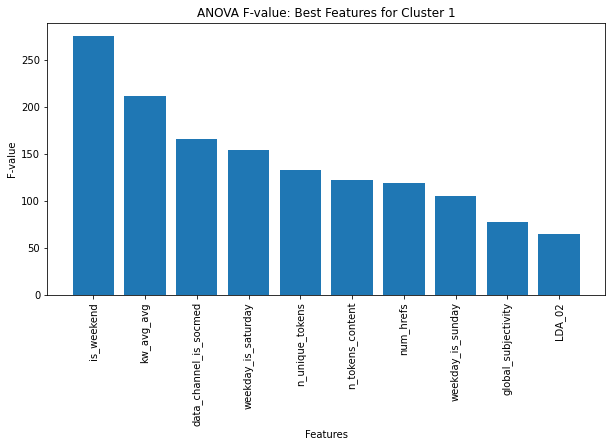

In [ ]:
#Extract the 10 best features for cluster 1
fval_best_features1 = extract_best_features(f_data_clust1[0], X1.columns.values, n=10)
fval_best_features1

# plot the best features for cluster 1
plt.figure(figsize=(10,5))
plt.bar(fval_best_features1[:,1], fval_best_features1[:,0])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('F-value')
plt.title('ANOVA F-value: Best Features for Cluster 1')
plt.show()


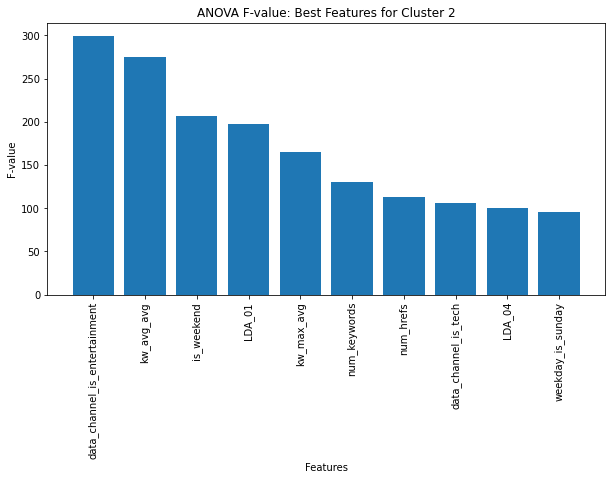

In [ ]:
#Extract the 10 best features for cluster 2
fval_best_features2 = extract_best_features(f_data_clust2[0], X2.columns.values, n=10)
fval_best_features2

# plot the best features for cluster 2
plt.figure(figsize=(10,5))
plt.bar(fval_best_features2[:,1], fval_best_features2[:,0])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('F-value')
plt.title('ANOVA F-value: Best Features for Cluster 2')
plt.show()


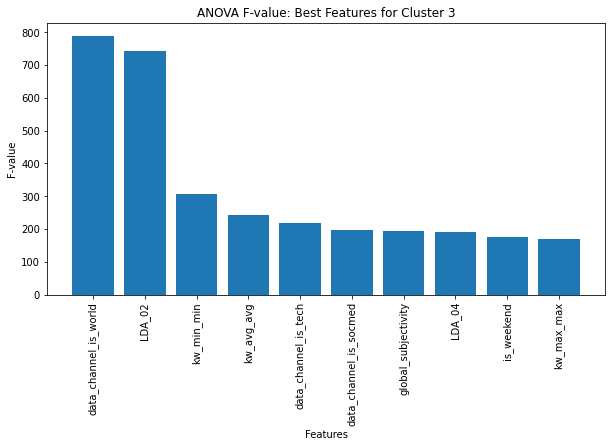

In [ ]:
#Extract the 10 best features for cluster 3
fval_best_features3 = extract_best_features(f_data_clust3[0], X3.columns.values, n=10)
fval_best_features3

# plot the best features for cluster 3
plt.figure(figsize=(10,5))
plt.bar(fval_best_features3[:,1], fval_best_features3[:,0])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('F-value')
plt.title('ANOVA F-value: Best Features for Cluster 3')
plt.show()

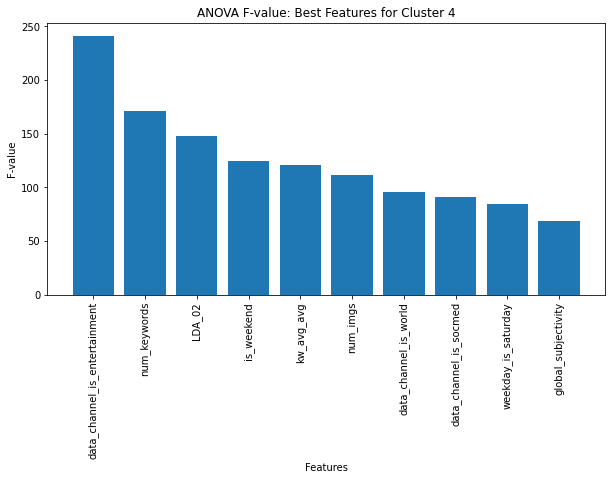

In [ ]:
#Extract the 10 best features for cluster 4
fval_best_features4 = extract_best_features(f_data_clust4[0], X4.columns.values, n=10)
fval_best_features4

# plot the best features for cluster 4
plt.figure(figsize=(10,5))
plt.bar(fval_best_features4[:,1], fval_best_features4[:,0])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('F-value')
plt.title('ANOVA F-value: Best Features for Cluster 4')
plt.show()

### Mutual Information 

In [ ]:
# Mutual Information future selection
# the input variable are the numerical features of each article
# the target ooutput variable is the categorical label popularity
from sklearn.feature_selection import mutual_info_classif

# Mutual information for cluster 1
mi_data_clust1 = mutual_info_classif(X1, y1)

# Mutual information for cluster 2
mi_data_clust2 = mutual_info_classif(X2, y2)

# Mutual information for cluster 3
mi_data_clust3 = mutual_info_classif(X3, y3)

# Mutual information for cluster 4
mi_data_clust4 = mutual_info_classif(X4, y4)

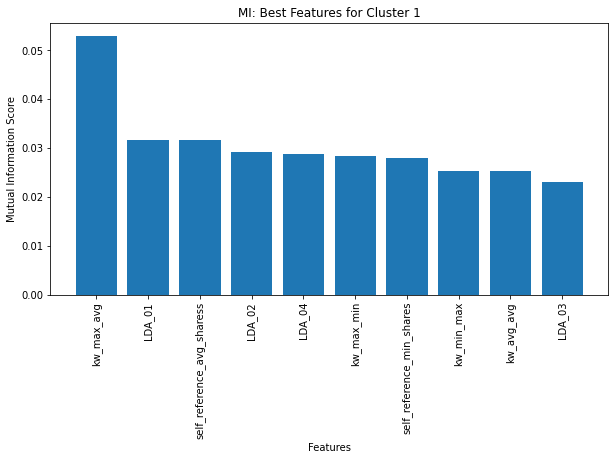

In [ ]:
#Extract the 10 best features for cluster 1
mi_best_features1 = extract_best_features(mi_data_clust1, X1.columns.values, n=10)

# plot the best features for cluster 1
plt.figure(figsize=(10,5))
plt.bar(mi_best_features1[:,1], mi_best_features1[:,0])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('MI: Best Features for Cluster 1')
plt.show()

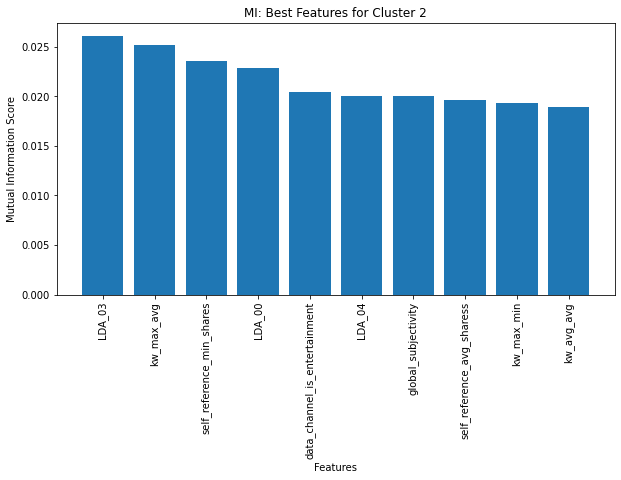

In [ ]:
#Extract the 10 best features for cluster 2
mi_best_features2 = extract_best_features(mi_data_clust2, X2.columns.values, n=10)

# plot the best features for cluster 2
plt.figure(figsize=(10,5))
plt.bar(mi_best_features2[:,1], mi_best_features2[:,0])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('MI: Best Features for Cluster 2')
plt.show()

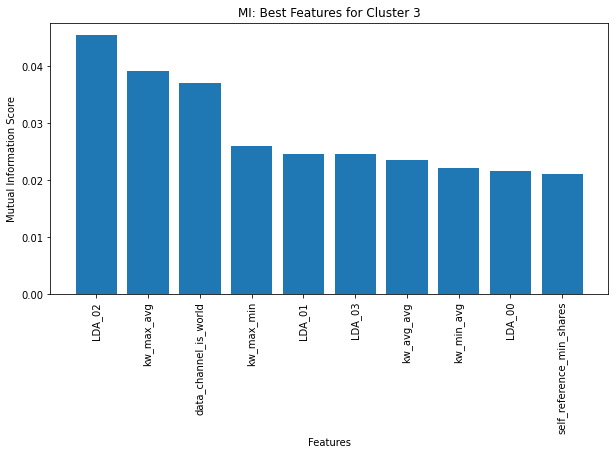

In [ ]:
#Extract the 10 best features for cluster 3
mi_best_features3 = extract_best_features(mi_data_clust3, X3.columns.values, n=10)

# plot the best features for cluster 3
plt.figure(figsize=(10,5))
plt.bar(mi_best_features3[:,1], mi_best_features3[:,0])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('MI: Best Features for Cluster 3')
plt.show()

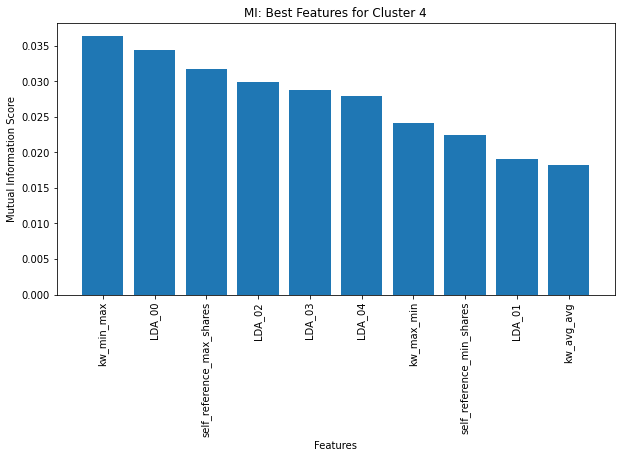

In [ ]:
#Extract the 10 best features for cluster 4
mi_best_features4 = extract_best_features(mi_data_clust4, X4.columns.values, n=10)

# plot the best features for cluster 4
plt.figure(figsize=(10,5))
plt.bar(mi_best_features4[:,1], mi_best_features4[:,0])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('MI: Best Features for Cluster 4')
plt.show()

## Classification of Online News Popularity

Since the mission of this project is to predict weather an online news article is popular or not, rather than to build a regression model that predicted how many times an article would eventually be shared, the problem is treated as a binary classification of popular and unpopular using the following 5 models: 

- Logistic regression

- KNN

- Decision trees

- Random Forest

- SVMs

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

ANOVA F-value

In [ ]:
def logistic_regression_news_model(name: str, target_labels, X, fval_best_features):

    labelEn = LabelEncoder()
    target_labels = labelEn.fit_transform(target_labels)

    unused_features = list(set(X.columns.values) - set(fval_best_features[:,1]))
    data_cluster_fval = X.drop(unused_features, axis=1, inplace=False)

    X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(data_cluster_fval, target_labels, test_size=0.3, shuffle=False)

    lr = LogisticRegression().fit(X_train_LR, y_train_LR)
    y_pred_LR = lr.predict(X_test_LR)

    print(f"{name} - Linear regression Results for ANOVA F-value:")
    print(classification_report(y_test_LR, y_pred_LR))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_LR, y_pred_LR))
    print("\n")

    return Counter(y_pred_LR), accuracy_score(y_test_LR,y_pred_LR), precision_score(y_test_LR,y_pred_LR), recall_score(y_test_LR,y_pred_LR), f1_score(y_test_LR,y_pred_LR)



lr1 = logistic_regression_news_model("Cluster 1", y1.values, X1, fval_best_features1)
lr2 = logistic_regression_news_model("Cluster 2", y2.values, X2, fval_best_features2)
lr3 = logistic_regression_news_model("Cluster 3", y3.values, X3, fval_best_features3)
lr4 = logistic_regression_news_model("Cluster 4", y4.values, X4, fval_best_features4)

Cluster 1 - Linear regression Results for ANOVA F-value:
              precision    recall  f1-score   support

           0       0.73      0.56      0.63      1430
           1       0.61      0.77      0.68      1294

    accuracy                           0.66      2724
   macro avg       0.67      0.66      0.66      2724
weighted avg       0.67      0.66      0.66      2724

Confusion Matrix:
[[804 626]
 [304 990]]


Cluster 2 - Linear regression Results for ANOVA F-value:
              precision    recall  f1-score   support

           0       0.63      0.48      0.55      1111
           1       0.68      0.79      0.73      1534

    accuracy                           0.66      2645
   macro avg       0.65      0.64      0.64      2645
weighted avg       0.66      0.66      0.65      2645

Confusion Matrix:
[[ 536  575]
 [ 319 1215]]


Cluster 3 - Linear regression Results for ANOVA F-value:
              precision    recall  f1-score   support

           0       0.57      0

<ipython-input-74-c646970faa9e>:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x, labels)


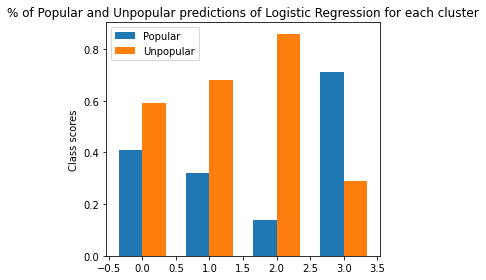

In [ ]:
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

p1 = round(lr1[0][0] / (lr1[0][0] + lr1[0][1]), 2)
p2 = round(lr2[0][0] / (lr2[0][0] + lr2[0][1]), 2)
p3 = round(lr3[0][0] / (lr3[0][0] + lr3[0][1]), 2)
p4 = round(lr4[0][0] / (lr4[0][0] + lr4[0][1]), 2)

men_means = [p1, p2, p3, p4]
women_means = [1-p1, 1-p2, 1-p3, 1-p4]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Popular')
rects2 = ax.bar(x + width/2, women_means, width, label='Unpopular')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Class scores')
ax.set_title('% of Popular and Unpopular predictions of Logistic Regression for each cluster')
ax.set_xticks(x, labels)
ax.legend()
#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Mutual Information

In [ ]:
def logistic_regression_news_model(name: str, target_labels, X, mi_best_features):

    labelEn = LabelEncoder()
    target_labels = labelEn.fit_transform(target_labels)

    unused_features = list(set(X.columns.values) - set(mi_best_features[:,1]))
    data_cluster_fval = X.drop(unused_features, axis=1, inplace=False)

    X_train, X_test, y_train, y_test = train_test_split(data_cluster_fval, target_labels, test_size=0.3, shuffle=False)

    lr = LogisticRegression().fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    print(f"{name} - Linear regression Results for ANOVA F-value:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

    return Counter(y_pred)



lr1 = logistic_regression_news_model("Cluster 1", y1.values, X1, mi_best_features1)
lr2 = logistic_regression_news_model("Cluster 2", y2.values, X2, mi_best_features2)
lr3 = logistic_regression_news_model("Cluster 3", y3.values, X3, mi_best_features3)
lr4 = logistic_regression_news_model("Cluster 4", y4.values, X4, mi_best_features4)



Cluster 1 - Linear regression Results for ANOVA F-value:
              precision    recall  f1-score   support

           0       0.62      0.72      0.67      1430
           1       0.63      0.52      0.57      1294

    accuracy                           0.63      2724
   macro avg       0.63      0.62      0.62      2724
weighted avg       0.63      0.63      0.62      2724

Confusion Matrix:
[[1036  394]
 [ 624  670]]


Cluster 2 - Linear regression Results for ANOVA F-value:
              precision    recall  f1-score   support

           0       0.61      0.46      0.52      1111
           1       0.67      0.79      0.72      1534

    accuracy                           0.65      2645
   macro avg       0.64      0.62      0.62      2645
weighted avg       0.64      0.65      0.64      2645

Confusion Matrix:
[[ 509  602]
 [ 329 1205]]


Cluster 3 - Linear regression Results for ANOVA F-value:
              precision    recall  f1-score   support

           0       0.55   

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

ANOVA F-value

In [ ]:
def knn_news_model(name: str, target_labels, X, fval_best_features):
    #LR for cluster 1
    labelEn = LabelEncoder()
    target_labels = labelEn.fit_transform(target_labels)

    unused_features = list(set(X.columns.values) - set(fval_best_features[:,1]))
    data_cluster_fval = X.drop(unused_features, axis=1, inplace=False)

    X_train_KN, X_test_KN, y_train_KN, y_test_KN = train_test_split(data_cluster_fval, target_labels, test_size=0.3, shuffle=False)

    knn = KNeighborsClassifier(n_neighbors=50).fit(X_train_KN, y_train_KN)
    y_pred_KN = knn.predict(X_test_KN)

    print(f"{name} - KNN (k=50) for ANOVA F-value:")
    print(classification_report(y_test_KN, y_pred_KN))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_KN, y_pred_KN))
    print("\n")

    return Counter(y_pred_KN), accuracy_score(y_test_KN,y_pred_KN), precision_score(y_test_KN,y_pred_KN), recall_score(y_test_KN,y_pred_KN), f1_score(y_test_KN,y_pred_KN)

knn1 = knn_news_model("Cluster 1", y1.values, X1, fval_best_features1)
knn2 = knn_news_model("Cluster 2", y2.values, X2, fval_best_features2)
knn3 = knn_news_model("Cluster 3", y3.values, X3, fval_best_features3)
knn4 = knn_news_model("Cluster 3", y4.values, X4, fval_best_features4)
'''
for k in [5, 10, 15, 20, 30, 40, 50]:
    knn_news_model("Cluster 2", k, y2.values, X2, fval_best_features2)
for k in [5, 10, 15, 20, 30, 40, 50]:
    knn_news_model("Cluster 3", k, y3.values, X3, fval_best_features3)
for k in [5, 10, 15, 20, 30, 40, 50]:
    knn_news_model("Cluster 4", k, y4.values, X4, fval_best_features4)
    
'''


Cluster 1 - KNN (k=50) for ANOVA F-value:
              precision    recall  f1-score   support

           0       0.68      0.63      0.66      1430
           1       0.62      0.67      0.65      1294

    accuracy                           0.65      2724
   macro avg       0.65      0.65      0.65      2724
weighted avg       0.65      0.65      0.65      2724

Confusion Matrix:
[[905 525]
 [423 871]]


Cluster 2 - KNN (k=50) for ANOVA F-value:
              precision    recall  f1-score   support

           0       0.61      0.44      0.51      1111
           1       0.66      0.80      0.72      1534

    accuracy                           0.65      2645
   macro avg       0.64      0.62      0.62      2645
weighted avg       0.64      0.65      0.64      2645

Confusion Matrix:
[[ 489  622]
 [ 309 1225]]


Cluster 3 - KNN (k=50) for ANOVA F-value:
              precision    recall  f1-score   support

           0       0.55      0.34      0.42      1199
           1       0.

'\nfor k in [5, 10, 15, 20, 30, 40, 50]:\n    knn_news_model("Cluster 2", k, y2.values, X2, fval_best_features2)\nfor k in [5, 10, 15, 20, 30, 40, 50]:\n    knn_news_model("Cluster 3", k, y3.values, X3, fval_best_features3)\nfor k in [5, 10, 15, 20, 30, 40, 50]:\n    knn_news_model("Cluster 4", k, y4.values, X4, fval_best_features4)\n    \n'

Mutual Information

In [ ]:
def knn_news_model(name: str, k, target_labels, X, mi_best_features):
    #LR for cluster 1
    labelEn = LabelEncoder()
    target_labels = labelEn.fit_transform(target_labels)

    unused_features = list(set(X.columns.values) - set(mi_best_features[:,1]))
    data_cluster_fval = X.drop(unused_features, axis=1, inplace=False)

    X_train, X_test, y_train, y_test = train_test_split(data_cluster_fval, target_labels, test_size=0.3, shuffle=False)

    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    print(f"{name} - KNN (k={k})for ANOVA F-value:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")


for k in [5, 10, 15, 20, 30, 40, 50]:
    knn_news_model("Cluster 1", k, y1.values, X1, mi_best_features1)
for k in [5, 10, 15, 20, 30, 40, 50]:
    knn_news_model("Cluster 2", k, y2.values, X2, mi_best_features2)
for k in [5, 10, 15, 20, 30, 40, 50]:
    knn_news_model("Cluster 3", k, y3.values, X3, mi_best_features3)
for k in [5, 10, 15, 20, 30, 40, 50]:
    knn_news_model("Cluster 4", k, y4.values, X4, mi_best_features4)

Cluster 1 - KNN (k=5)for ANOVA F-value:
              precision    recall  f1-score   support

           0       0.61      0.62      0.62      1430
           1       0.57      0.57      0.57      1294

    accuracy                           0.59      2724
   macro avg       0.59      0.59      0.59      2724
weighted avg       0.59      0.59      0.59      2724

Confusion Matrix:
[[886 544]
 [562 732]]


Cluster 1 - KNN (k=10)for ANOVA F-value:
              precision    recall  f1-score   support

           0       0.61      0.72      0.66      1430
           1       0.61      0.49      0.54      1294

    accuracy                           0.61      2724
   macro avg       0.61      0.60      0.60      2724
weighted avg       0.61      0.61      0.60      2724

Confusion Matrix:
[[1025  405]
 [ 665  629]]


Cluster 1 - KNN (k=15)for ANOVA F-value:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      1430
           1       0.60  

### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

ANOVA F-value

In [ ]:
def decision_tree_news_model(name: str, target_labels, X, fval_best_features):

    labelEn = LabelEncoder()
    target_labels = labelEn.fit_transform(target_labels)

    unused_features = list(set(X.columns.values) - set(fval_best_features[:,1]))
    data_cluster_fval = X.drop(unused_features, axis=1, inplace=False)

    X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(data_cluster_fval, target_labels, test_size=0.3, shuffle=False)

    dt = DecisionTreeClassifier().fit(X_train_DT, y_train_DT)
    y_pred_DT = dt.predict(X_test_DT)

    print(f"{name} - Decision Tree Results for MI:")
    print(classification_report(y_test_DT, y_pred_DT))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_DT, y_pred_DT))
    print("\n")
    return Counter(y_pred_DT), accuracy_score(y_test_DT,y_pred_DT), precision_score(y_test_DT,y_pred_DT), recall_score(y_test_DT,y_pred_DT), f1_score(y_test_DT,y_pred_DT)

dt1 = decision_tree_news_model("Cluster 1", y1.values, X1, fval_best_features1)
dt2 = decision_tree_news_model("Cluster 2", y2.values, X2, fval_best_features2)
dt3 = decision_tree_news_model("Cluster 3", y3.values, X3, fval_best_features3)
dt4 = decision_tree_news_model("Cluster 4", y4.values, X4, fval_best_features4)


Cluster 1 - Decision Tree Results for MI:
              precision    recall  f1-score   support

           0       0.59      0.58      0.59      1430
           1       0.55      0.55      0.55      1294

    accuracy                           0.57      2724
   macro avg       0.57      0.57      0.57      2724
weighted avg       0.57      0.57      0.57      2724

Confusion Matrix:
[[836 594]
 [582 712]]


Cluster 2 - Decision Tree Results for MI:
              precision    recall  f1-score   support

           0       0.48      0.55      0.51      1111
           1       0.64      0.57      0.60      1534

    accuracy                           0.56      2645
   macro avg       0.56      0.56      0.56      2645
weighted avg       0.57      0.56      0.56      2645

Confusion Matrix:
[[613 498]
 [664 870]]


Cluster 3 - Decision Tree Results for MI:
              precision    recall  f1-score   support

           0       0.40      0.44      0.42      1199
           1       0.68  

Mutual Information

In [ ]:
def decision_tree_news_model(name: str, target_labels, X, mi_best_features):

    labelEn = LabelEncoder()
    target_labels = labelEn.fit_transform(target_labels)

    unused_features = list(set(X.columns.values) - set(mi_best_features[:,1]))
    data_cluster_fval = X.drop(unused_features, axis=1, inplace=False)

    X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(data_cluster_fval, target_labels, test_size=0.3, shuffle=False)

    dt = DecisionTreeClassifier().fit(X_train_DT, y_train_DT)
    y_pred_DT = dt.predict(X_test_DT)

    print(f"{name} - Decision Tree Results for MI:")
    print(classification_report(y_test_DT, y_pred_DT))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_DT, y_pred_DT))
    print("\n")

    return Counter(y_pred_DT)


dt1 = decision_tree_news_model("Cluster 1", y1.values, X1, mi_best_features1)
dt2 = decision_tree_news_model("Cluster 2", y2.values, X2, mi_best_features2)
dt3 = decision_tree_news_model("Cluster 3", y3.values, X3, mi_best_features3)
dt4 = decision_tree_news_model("Cluster 4", y4.values, X4, mi_best_features4)


Cluster 1 - Decision Tree Results for MI:
              precision    recall  f1-score   support

           0       0.60      0.59      0.59      1430
           1       0.56      0.57      0.56      1294

    accuracy                           0.58      2724
   macro avg       0.58      0.58      0.58      2724
weighted avg       0.58      0.58      0.58      2724

Confusion Matrix:
[[839 591]
 [552 742]]


Cluster 2 - Decision Tree Results for MI:
              precision    recall  f1-score   support

           0       0.47      0.51      0.49      1111
           1       0.62      0.58      0.60      1534

    accuracy                           0.55      2645
   macro avg       0.55      0.55      0.54      2645
weighted avg       0.56      0.55      0.55      2645

Confusion Matrix:
[[567 544]
 [642 892]]


Cluster 3 - Decision Tree Results for MI:
              precision    recall  f1-score   support

           0       0.41      0.48      0.44      1199
           1       0.70  

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

ANOVA f-value

In [ ]:
def random_forrest_news_model(name: str, target_labels, X, fval_best_features):

    labelEn = LabelEncoder()
    target_labels = labelEn.fit_transform(target_labels)

    unused_features = list(set(X.columns.values) - set(fval_best_features[:,1]))
    data_cluster_fval = X.drop(unused_features, axis=1, inplace=False)

    X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(data_cluster_fval, target_labels, test_size=0.3, shuffle=False)

    rf = RandomForestClassifier().fit(X_train_RF, y_train_RF)
    y_pred_RF = rf.predict(X_test_RF)

    print(f"{name} - Random Forrest for ANOVA F-values:")
    print(classification_report(y_test_RF, y_pred_RF))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_RF, y_pred_RF))
    print("\n")

    return Counter(y_pred_RF), accuracy_score(y_test_RF,y_pred_RF), precision_score(y_test_RF,y_pred_RF), recall_score(y_test_RF,y_pred_RF), f1_score(y_test_RF,y_pred_RF)


rf1 = random_forrest_news_model("Cluster 1", y1.values, X1, fval_best_features1)
rf2 = random_forrest_news_model("Cluster 2", y2.values, X2, fval_best_features2)
rf3 = random_forrest_news_model("Cluster 3", y3.values, X3, fval_best_features3)
rf4 = random_forrest_news_model("Cluster 4", y4.values, X4, fval_best_features4)


Cluster 1 - Random Forrest for ANOVA F-values:
              precision    recall  f1-score   support

           0       0.66      0.67      0.66      1430
           1       0.63      0.61      0.62      1294

    accuracy                           0.64      2724
   macro avg       0.64      0.64      0.64      2724
weighted avg       0.64      0.64      0.64      2724

Confusion Matrix:
[[958 472]
 [499 795]]


Cluster 2 - Random Forrest for ANOVA F-values:
              precision    recall  f1-score   support

           0       0.57      0.55      0.56      1111
           1       0.68      0.70      0.69      1534

    accuracy                           0.64      2645
   macro avg       0.63      0.63      0.63      2645
weighted avg       0.64      0.64      0.64      2645

Confusion Matrix:
[[ 614  497]
 [ 459 1075]]


Cluster 3 - Random Forrest for ANOVA F-values:
              precision    recall  f1-score   support

           0       0.50      0.40      0.45      1199
      

Mutual Information

In [ ]:
def random_forrest_news_model(name: str, target_labels, X, mi_best_features):

    labelEn = LabelEncoder()
    target_labels = labelEn.fit_transform(target_labels)

    unused_features = list(set(X.columns.values) - set(mi_best_features[:,1]))
    data_cluster_fval = X.drop(unused_features, axis=1, inplace=False)

    X_train, X_test, y_train, y_test = train_test_split(data_cluster_fval, target_labels, test_size=0.3, shuffle=False)

    rf = RandomForestClassifier().fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    print(f"{name} - Random Forrest Results for MI:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")
    print(f1_score(y_test,y_pred))

    return Counter(y_pred)


rf1 = random_forrest_news_model("Cluster 1", y1.values, X1, mi_best_features1)
rf2 = random_forrest_news_model("Cluster 2", y2.values, X2, mi_best_features2)
rf3 = random_forrest_news_model("Cluster 3", y3.values, X3, mi_best_features3)
rf4 = random_forrest_news_model("Cluster 4", y4.values, X4, mi_best_features4)

Cluster 1 - Random Forrest Results for MI:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      1430
           1       0.63      0.56      0.59      1294

    accuracy                           0.63      2724
   macro avg       0.63      0.63      0.63      2724
weighted avg       0.63      0.63      0.63      2724

Confusion Matrix:
[[1001  429]
 [ 567  727]]


0.593469387755102
Cluster 2 - Random Forrest Results for MI:
              precision    recall  f1-score   support

           0       0.58      0.49      0.53      1111
           1       0.67      0.74      0.70      1534

    accuracy                           0.63      2645
   macro avg       0.62      0.61      0.62      2645
weighted avg       0.63      0.63      0.63      2645

Confusion Matrix:
[[ 546  565]
 [ 402 1132]]


0.7007118539151965
Cluster 3 - Random Forrest Results for MI:
              precision    recall  f1-score   support

           0       0.50      0.

### SVMs

In [ ]:
from sklearn.svm import SVC

ANOVA F-value

In [ ]:
def svm_news_model(name: str, target_labels, X, fval_best_features):

    labelEn = LabelEncoder()
    target_labels = labelEn.fit_transform(target_labels)

    unused_features = list(set(X.columns.values) - set(fval_best_features[:,1]))
    data_cluster_fval = X.drop(unused_features, axis=1, inplace=False)

    X_train_SV, X_test_SV, y_train_SV, y_test_SV = train_test_split(data_cluster_fval, target_labels, test_size=0.3, shuffle=False)

    svm = SVC().fit(X_train_SV, y_train_SV)
    y_pred_SV = svm.predict(X_test_SV)

    print(f"{name} - SVM for ANOVA F-values:")
    print(classification_report(y_test_SV, y_pred_SV))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_SV, y_pred_SV))
    print("\n")

    return Counter(y_pred_SV), accuracy_score(y_test_SV,y_pred_SV), precision_score(y_test_SV,y_pred_SV), recall_score(y_test_SV,y_pred_SV), f1_score(y_test_SV,y_pred_SV)
    

svm1 = svm_news_model("Cluster 1", y1.values, X1, fval_best_features1)
svm2 = svm_news_model("Cluster 2", y2.values, X2, fval_best_features2)
svm3 = svm_news_model("Cluster 3", y3.values, X3, fval_best_features3)
svm4 = svm_news_model("Cluster 4", y4.values, X4, fval_best_features4)


Cluster 1 - SVM for ANOVA F-values:
              precision    recall  f1-score   support

           0       0.73      0.54      0.62      1430
           1       0.61      0.78      0.68      1294

    accuracy                           0.65      2724
   macro avg       0.67      0.66      0.65      2724
weighted avg       0.67      0.65      0.65      2724

Confusion Matrix:
[[ 778  652]
 [ 288 1006]]


Cluster 2 - SVM for ANOVA F-values:
              precision    recall  f1-score   support

           0       0.62      0.49      0.55      1111
           1       0.68      0.78      0.73      1534

    accuracy                           0.66      2645
   macro avg       0.65      0.64      0.64      2645
weighted avg       0.65      0.66      0.65      2645

Confusion Matrix:
[[ 548  563]
 [ 340 1194]]


Cluster 3 - SVM for ANOVA F-values:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1199
           1       0.65      1.00  

Mutual Information

In [ ]:
def svm_news_model(name: str, target_labels, X, mi_best_features):

    labelEn = LabelEncoder()
    target_labels = labelEn.fit_transform(target_labels)

    unused_features = list(set(X.columns.values) - set(mi_best_features[:,1]))
    data_cluster_fval = X.drop(unused_features, axis=1, inplace=False)

    X_train, X_test, y_train, y_test = train_test_split(data_cluster_fval, target_labels, test_size=0.3, shuffle=False)

    svm = SVC().fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    print(f"{name} - SVM for MI:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

    return Counter(y_pred)


svm1 = svm_news_model("Cluster 1", y1.values, X1, mi_best_features1)
svm2 = svm_news_model("Cluster 2", y2.values, X2, mi_best_features2)
svm3 = svm_news_model("Cluster 3", y3.values, X3, mi_best_features3)
svm4 = svm_news_model("Cluster 4", y4.values, X4, mi_best_features4)

Cluster 1 - SVM for MI:
              precision    recall  f1-score   support

           0       0.66      0.55      0.60      1430
           1       0.58      0.69      0.63      1294

    accuracy                           0.62      2724
   macro avg       0.62      0.62      0.62      2724
weighted avg       0.62      0.62      0.61      2724

Confusion Matrix:
[[790 640]
 [407 887]]


Cluster 2 - SVM for MI:
              precision    recall  f1-score   support

           0       0.62      0.42      0.50      1111
           1       0.66      0.81      0.73      1534

    accuracy                           0.65      2645
   macro avg       0.64      0.62      0.62      2645
weighted avg       0.64      0.65      0.63      2645

Confusion Matrix:
[[ 472  639]
 [ 288 1246]]


Cluster 3 - SVM for MI:
              precision    recall  f1-score   support

           0       0.53      0.44      0.48      1199
           1       0.72      0.79      0.75      2239

    accuracy        

## Outcomes

We visualized graph which implements the metrics of mentioned classifiers.

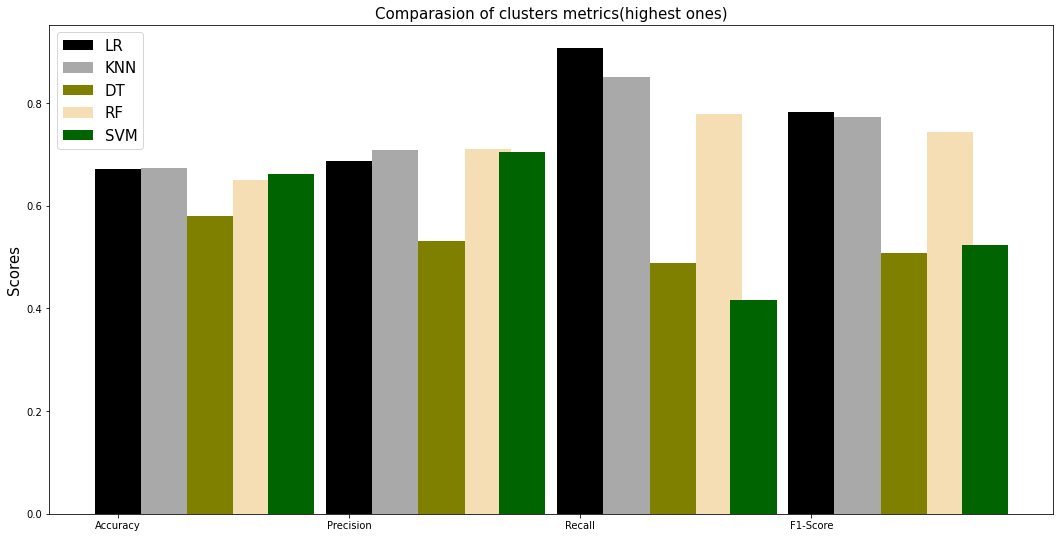

In [ ]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
lr_metrics =[0.6705403834979663, 0.6869506423258959, 0.9071428571428571, 0.7818391689111196]
kn_metrics =[0.674026728646136, 0.7078066914498141, 0.85, 0.7724137931034483]
dt_metrics = [0.5790629575402635, 0.53125, 0.48770491803278687, 0.5085470085470086]
rf_metrics = [ 0.6490412550842534, 0.7104404567699837, 0.7776785714285714, 0.742540494458652]
sv_metrics = [0.6614202049780381,0.7040110650069157,0.41721311475409834,0.5239320638188367]
x = np.arange(len(labels))  

fig, ax = plt.subplots(figsize=(18,9))
plt.bar(x, lr_metrics, width=0.2, label='LR',color='black')
plt.bar(x+0.2,kn_metrics,  width=0.2, label='KNN',color='darkgrey')
plt.bar(x+0.4, dt_metrics, width=0.2,label='DT',color='olive')
plt.bar(x+0.6,rf_metrics,width=0.2, label='RF',color="wheat")
plt.bar(x+0.75,sv_metrics, width=0.2, label='SVM',color="darkgreen")

plt.ylabel('Scores',fontsize=15)
plt.title("Comparasion of clusters metrics(highest ones)",fontsize=15)
plt.xticks(x, labels)
plt.legend(fontsize=15)
plt.show()
